<a href="https://colab.research.google.com/github/salmanromeo/System_Identification/blob/main/Lorenz96_PyMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PyMC to solve Lorenz 96 model**

**Install PyMC in the system**

In [ ]:
pip install PyMC3

**Import libraries**

In [14]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import torch
import pymc3 as pm

**Lorenz 96 model**

#####We consider the following ODE:
\begin{align}
        \dot{X}_k = X_{k-1} (X_{k+1} - X_{k-2}) - X_{k} + 10
    \end{align}
#####Initially we use $RK4$ to solve this ODE and generate data.

**Define Lorenz 96 model and RK4**

In [15]:
def lorenz96(x, F):
    N = len(x)
    dxdt = torch.zeros(N)
    for k in range(N):
        dxdt[k] = (x[(k + 1) % N] - x[(k - 2)% N]) * x[(k - 1)% N] - x[k] + F
    return dxdt

def rk4(x, F, dt):
    k1 = lorenz96(x, F)
    k2 = lorenz96(x + 0.5 * dt * k1, F)
    k3 = lorenz96(x + 0.5 * dt * k2, F)
    k4 = lorenz96(x + dt * k3, F)
    x_new = x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return x_new

**Set parameters**

In [16]:
# Set the number of States
N = 40

# Set the initial condition
x0 = torch.rand(N)

# Set the forcing term
F = 10.0

# Set the integration parameters
dt = 0.005;
t_start = 5.0
t_end = 10.0

# Create an array to store the time steps
t_steps = torch.arange(t_start, t_end, dt)
num_steps = len(t_steps)

# Create arrays to store the solutions
x_solution = torch.zeros((num_steps, N))
x_solution[0] = x0

# Number Of Parameters (For 2 neighbouring nodes)
N_P = 21; 

**Solve with RK4**

In [17]:
# Perform the integration
for n in range(1, num_steps):
    x_solution[n] = rk4(x_solution[n - 1], F, dt)

X_state=x_solution # True state vaues

**True RHS**

In [18]:
# True RHS
RHS_true = torch.zeros((num_steps, N)) 
for k in range(N):
    RHS_true[:,k]=(x_solution[:,(k + 1) % N] - x_solution[:,(k - 2)% N]) * x_solution[:,(k - 1)% N] - x_solution[:,k] + F

dx_dt_state=RHS_true; # True RHS

**Plot the Lorenz 96 model's states**

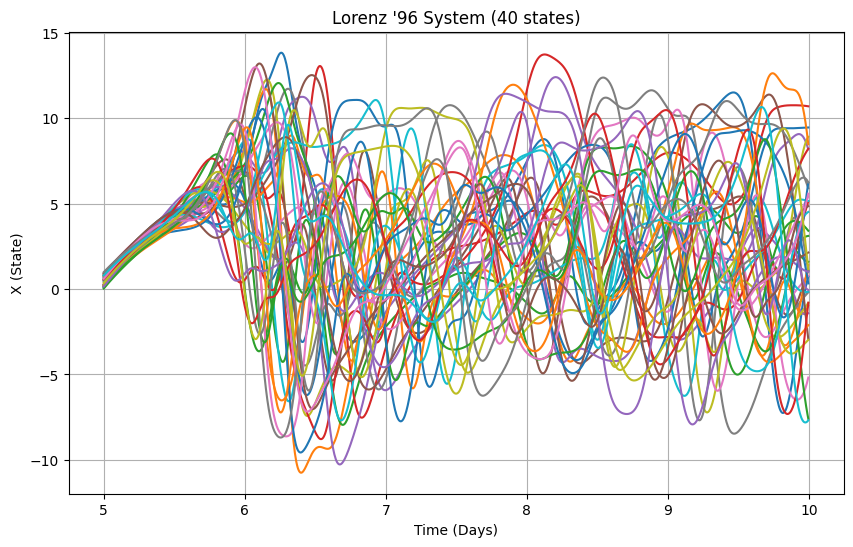

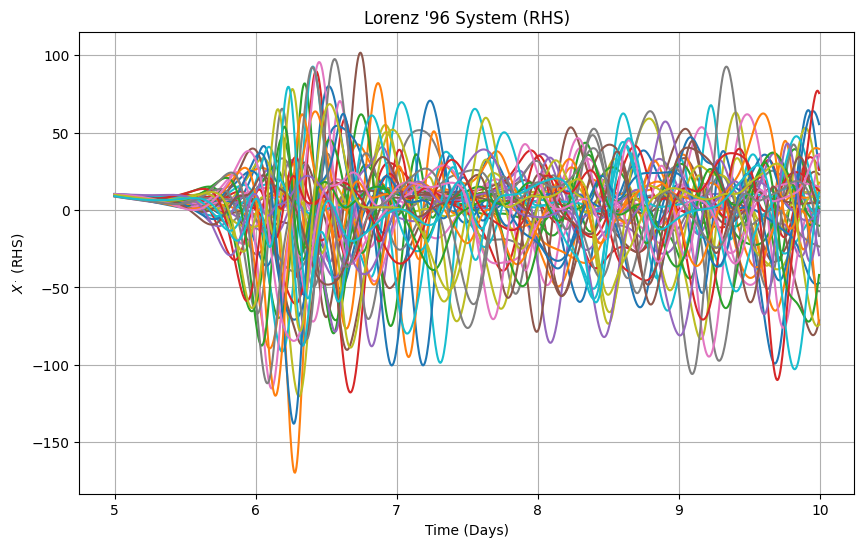

In [19]:
# Plot the solutions (X_state and X_dot)
plt.figure(figsize=(10, 6))
for k in range(N):
    plt.plot(t_steps, X_state[:, k], label=f'Variable {k+1}')
    plt.xlabel('Time')   
plt.xlabel('Time (Days)')
plt.ylabel('X (State)')
plt.title('Lorenz \'96 System (40 states)')
#plt.legend()
plt.grid(True)
plt.savefig('X_state.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
for k in range(N):
    plt.plot(t_steps, RHS_true[:, k], label=f'Variable {k+1}')
    plt.xlabel('Time')
plt.xlabel('Time (Days)')
plt.ylabel('$X^{.}$ (RHS)')
plt.title('Lorenz \'96 System (RHS)')
#plt.legend()
plt.grid(True)
plt.savefig('X_state_dot.png', dpi=300)
plt.show()

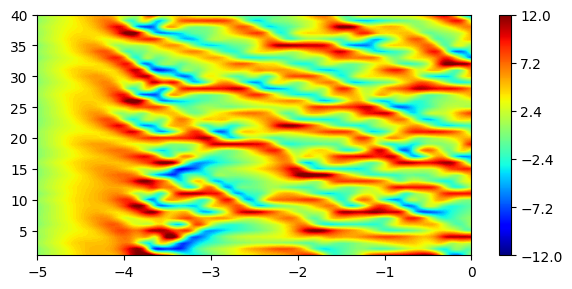

In [20]:
#%%
ns = int(t_start/dt)
nt = int(t_end/dt)
fr = 10.0
nf = 10         # frequency of observation
nb = int(nt/nf) # number of observation time
ti = np.linspace(-t_start,0,ns)
t = np.linspace(0,t_end,nt)
tobs = np.linspace(0,t_end,nb)
x = np.linspace(1,N,N)

Xi,Ti = np.meshgrid(x,ti,indexing='ij')

vmin = -12
vmax = 12
fig, ax = plt.subplots(figsize=(6,3))
cs = ax.contourf(Ti,Xi,X_state.T,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(X_state.T)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax,ticks=np.linspace(vmin, vmax, 6))

fig.tight_layout()
plt.show()

**Define our assumed dynamics**

#####We will assume that it will be a function of any possible quadratic feature that are a function of $x_{k-2}$, $x_{k-1}$, $x_{k}$, $x_{k+1}$ and $x_{k+2}$.
#####Or, we can say that:
\begin{align}
        RHS = d_0+d_{1}X_{k-2}+d_{2}X_{k-1}+d_{3}X_{k}+d_{4}X_{k+1}+d_{5}X_{k+2}+d_{6}X_{k-2}X_{k-1}+d_{7}X_{k-2}X_{k}+d_{8}X_{k-2}X_{k+1}+d_{9}X_{k-2}X_{k+2}+d_{10}X_{k-1}X_{k}+d_{11}X_{k-1}X_{k+1}+d_{12}X_{k-1}X_{k+2}+d_{13}X_{k}X_{k+1}+d_{14}X_{k}X_{k+2}+d_{15}X_{k+1}X_{k+2}+d_{16}X_{k-2}^2+d_{17}X_{k-1}^2+d_{18}X_{k}^2+d_{19}X_{k+1}^2+d_{20}X_{k+2}^2
    \end{align}

In [21]:
# Define the assumed dynamics:
def func(X, d):
    return (
        d[0] + d[1] * X[0] + d[2] * X[1] + d[3] * X[2] + d[4] * X[3] + d[5] * X[4] +
        d[6] * X[0] * X[1] + d[7] * X[0] * X[2] + d[8] * X[0] * X[3] + d[9] * X[0] * X[4] +
        d[10] * X[1] * X[2] + d[11] * X[1] * X[3] + d[12] * X[1] * X[4] +
        d[13] * X[2] * X[3] + d[14] * X[2] * X[4] +
        d[15] * X[3] * X[4] +
        d[16] * X[0]**2 + d[17] * X[1]**2 + d[18] * X[2]**2 + d[19] * X[3]**2 + d[20] * X[4]**2
    )

**Set the observed data for PyMC**

In [22]:
# Set the observed data
X_observed = np.vstack([
    X_state[:, (k - 2) % N].numpy(),
    X_state[:, (k - 1) % N].numpy(),
    X_state[:, k].numpy(),
    X_state[:, (k + 1) % N].numpy(),
    X_state[:, (k + 2) % N].numpy(),
]).T
Y_observed = dx_dt_state[:, k].numpy()

**Define the PyMC model**

In [23]:
# Define the PyMC model
with pm.Model() as model:
    # Priors for the parameters
    d = pm.Normal("d", mu=0, sd=2, shape=N_P)
    
    # Expected value (assumed dynamics)
    mu = func(X_observed.T, d)
    
    # Likelihood
    Y = pm.Normal("Y", mu=mu, sd=1, observed=Y_observed)
    
    # Perform Bayesian inference
    trace = pm.sample(1000, tune=1000, cores=1)

# Get the estimated parameter values
estimated_params = trace["d"].mean(axis=0)
print("Estimated parameters:", estimated_params)

/usr/local/lib/python3.10/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


Estimated parameters: [ 9.89724282e+00  5.90853472e-03  1.17450046e-02 -9.92175708e-01
  1.47408294e-02  9.62082805e-03 -1.00056980e+00 -5.88556441e-04
 -3.50940905e-04 -5.77567609e-04 -6.81375329e-04  9.98963190e-01
 -1.12946530e-03 -8.55766716e-04  1.12802659e-03 -1.72926445e-03
  2.27404407e-04  3.03102670e-04  3.16199395e-04 -5.18924298e-04
  4.39612754e-04]


**Plot the posterior distribution with reference values**

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


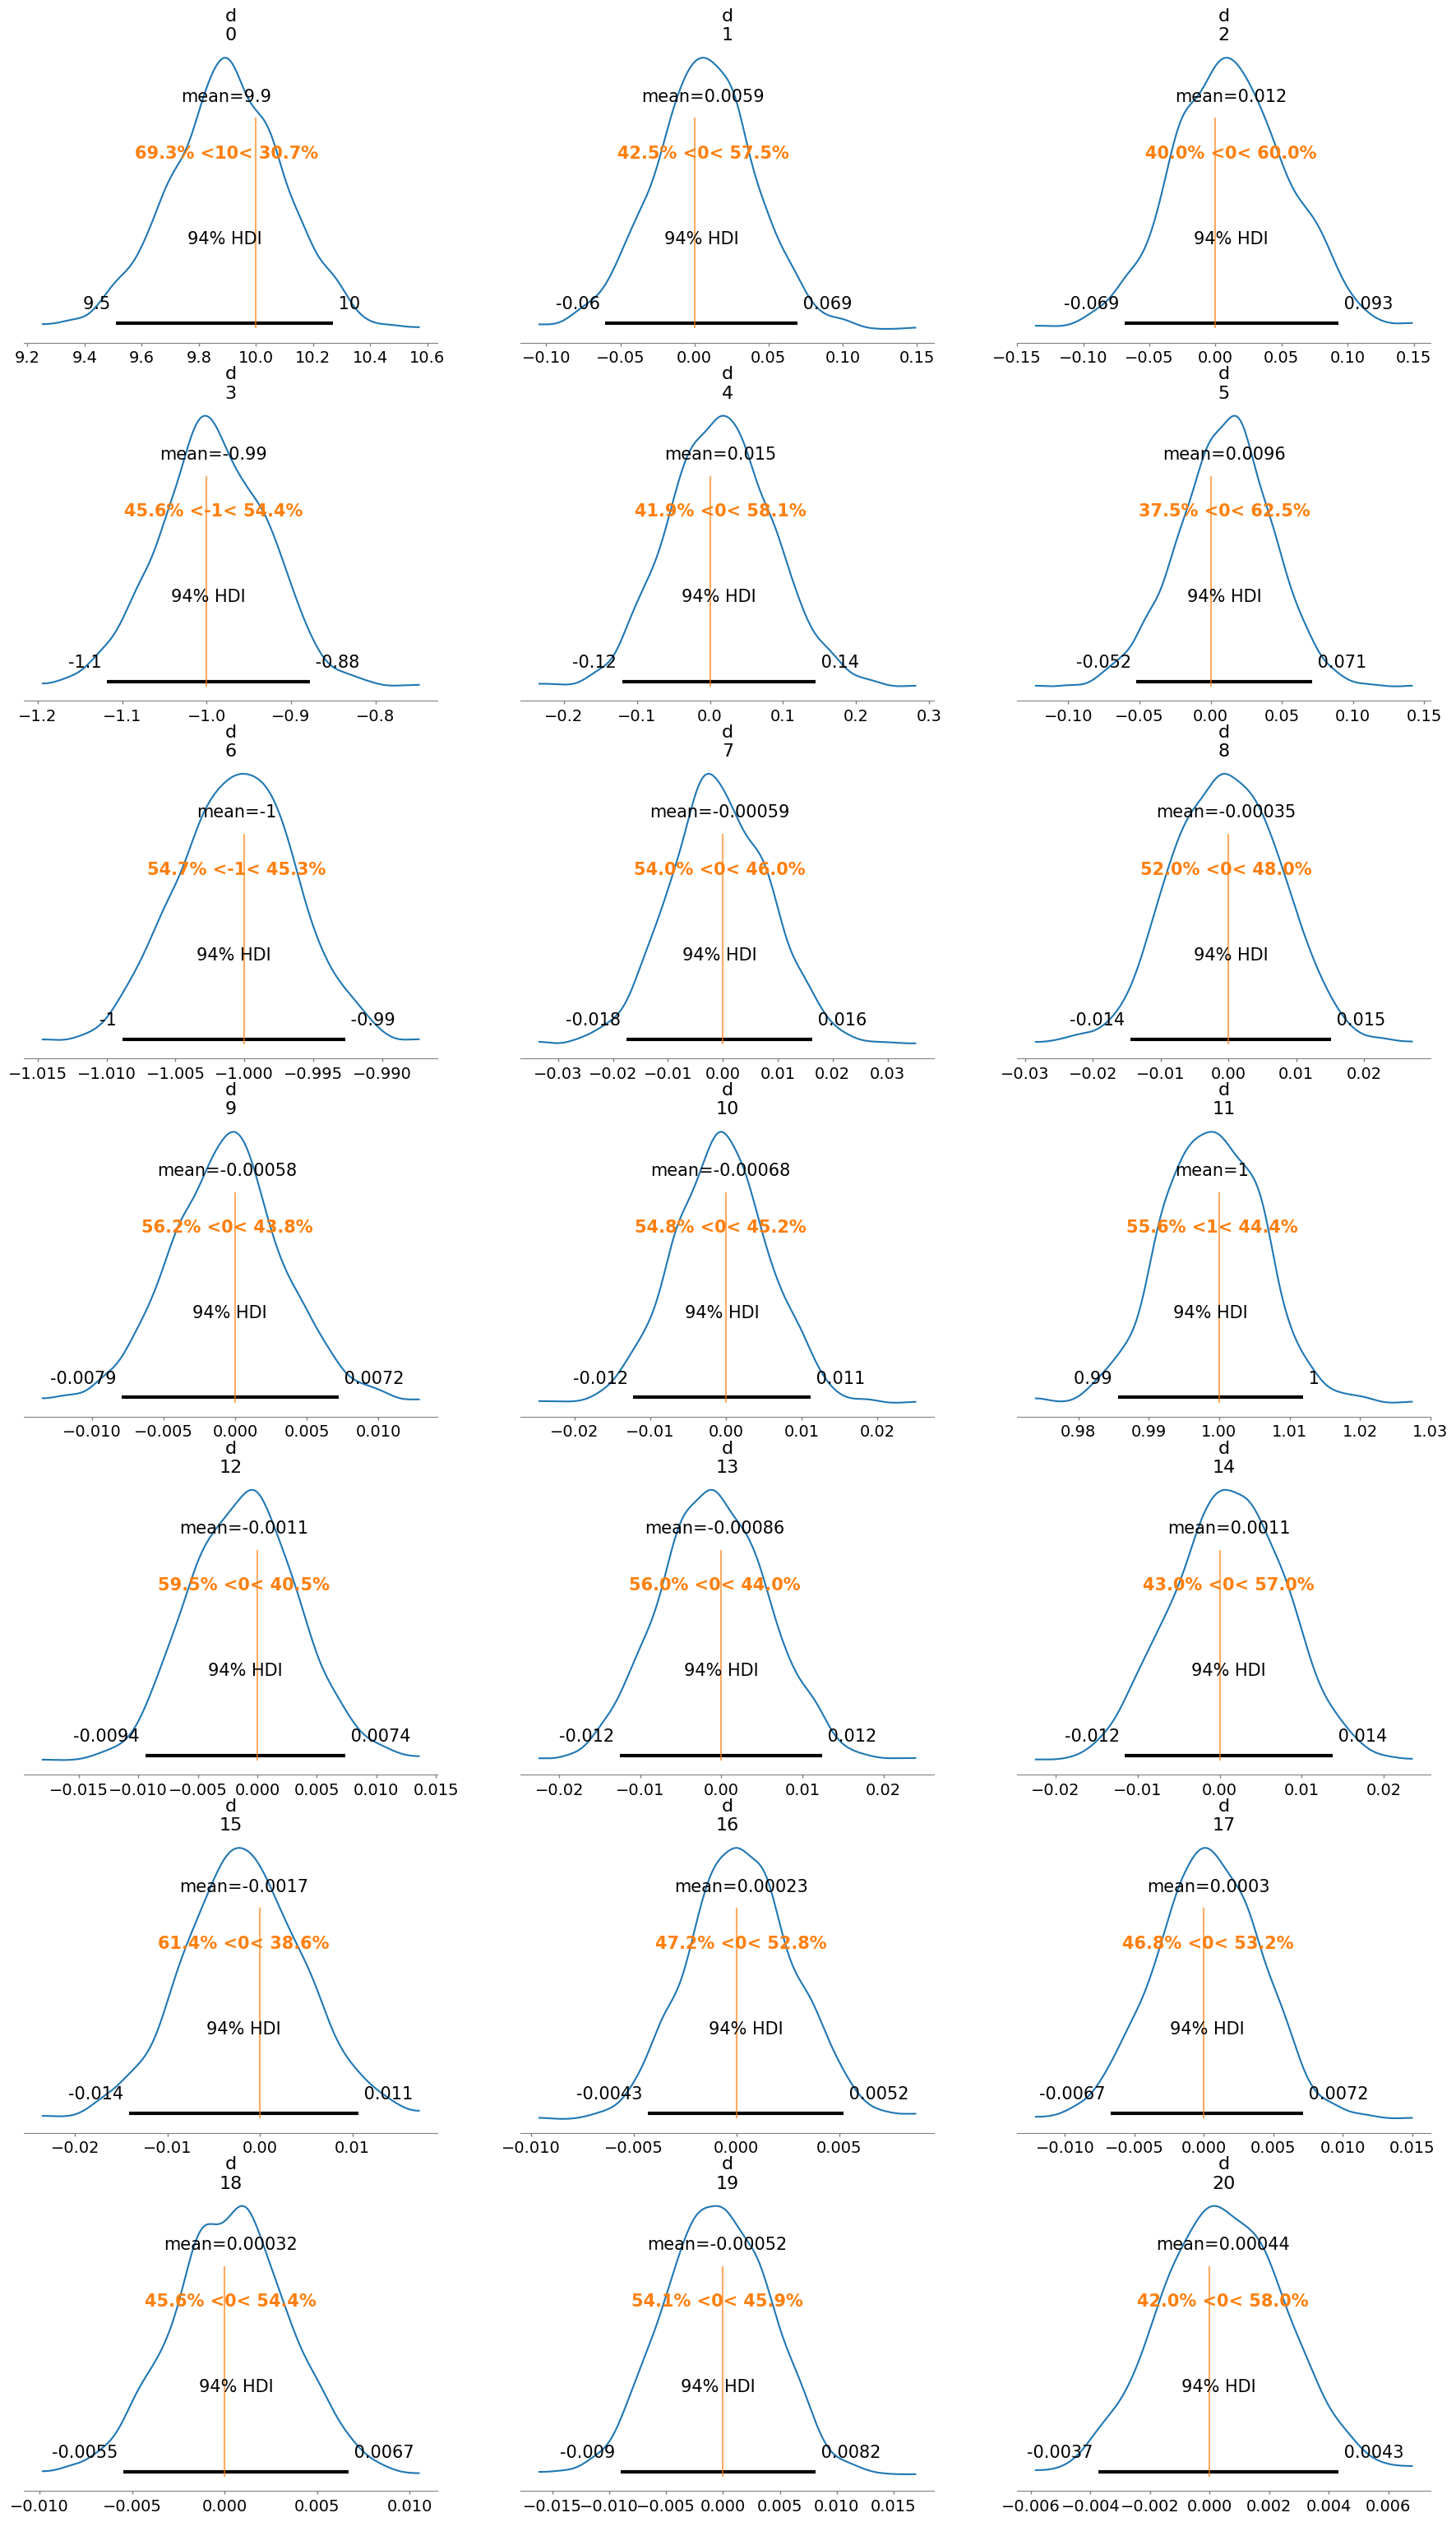

In [24]:
import arviz as az
# Define reference values for each parameter
ref_vals = [10, 0, 0, -1, 0, 0, -1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  # Replace with your desired reference values

# Plot the posterior distribution with reference values
az.plot_posterior(trace, var_names=["d"], ref_val=ref_vals)
plt.show()

Warmup:   0%|          | 0/2000 [1:18:09, ?it/s]


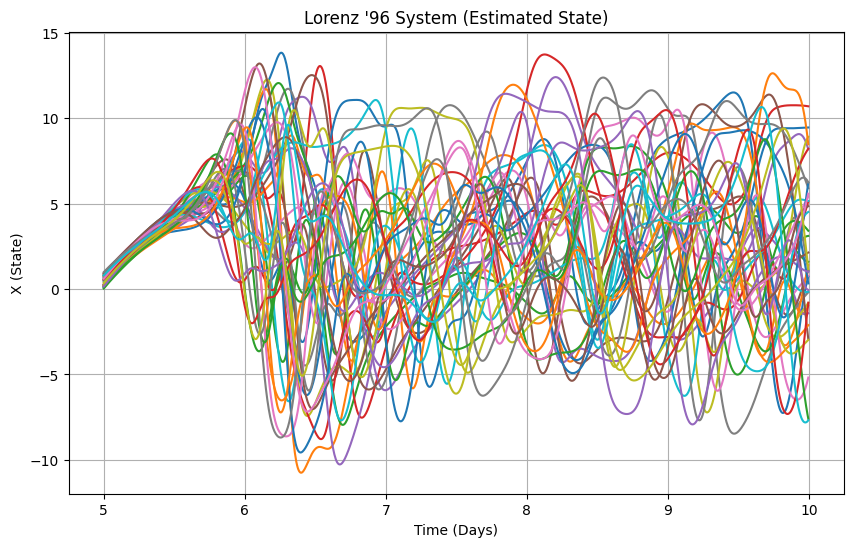

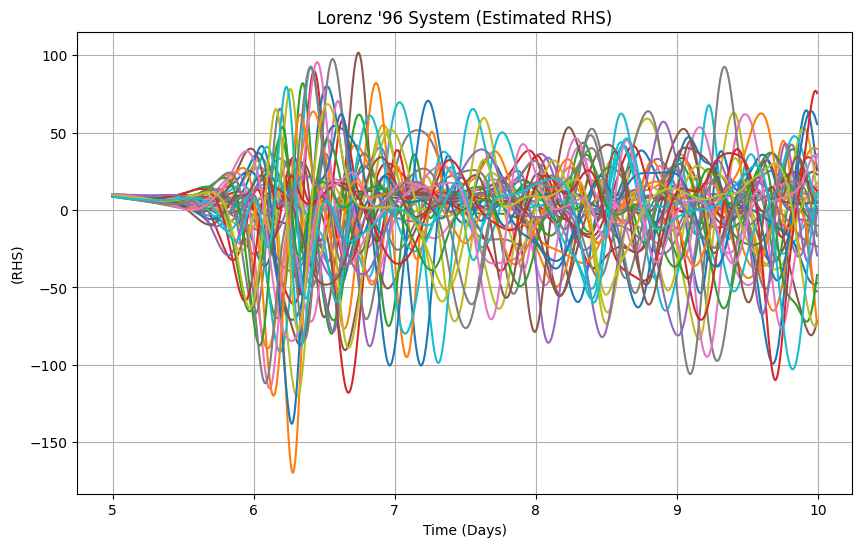

In [27]:
# Use the estimated parameter values
estimated_params = trace["d"].mean(axis=0)

# Define the assumed dynamics with estimated parameter values
def func(X, d):
    return (
        d[0] + d[1] * X[0] + d[2] * X[1] + d[3] * X[2] + d[4] * X[3] + d[5] * X[4] +
        d[6] * X[0] * X[1] + d[7] * X[0] * X[2] + d[8] * X[0] * X[3] + d[9] * X[0] * X[4] +
        d[10] * X[1] * X[2] + d[11] * X[1] * X[3] + d[12] * X[1] * X[4] +
        d[13] * X[2] * X[3] + d[14] * X[2] * X[4] +
        d[15] * X[3] * X[4] +
        d[16] * X[0]**2 + d[17] * X[1]**2 + d[18] * X[2]**2 + d[19] * X[3]**2 + d[20] * X[4]**2
    )

# Create arrays to store the solutions with estimated parameters
x_solution_estimated = torch.zeros((num_steps, N))
x_solution_estimated[0] = x0

# Perform the integration with estimated parameters
for n in range(1, num_steps):
    x_solution_estimated[n] = rk4(x_solution_estimated[n - 1], F, dt)

X_state_estimated = x_solution_estimated  # Estimated state values

# Calculate the estimated RHS
RHS_estimated = torch.zeros((num_steps, N))
for k in range(N):
    RHS_estimated[:, k] = func(
        torch.stack([
            X_state_estimated[:, (k - 2) % N],
            X_state_estimated[:, (k - 1) % N],
            X_state_estimated[:, k],
            X_state_estimated[:, (k + 1) % N],
            X_state_estimated[:, (k + 2) % N]
        ]),
        estimated_params
    )

# Plot the solutions (X_state and X_dot) with estimated parameters
plt.figure(figsize=(10, 6))
for k in range(N):
    plt.plot(t_steps, X_state_estimated[:, k], label=f'Variable {k+1}')
plt.xlabel('Time (Days)')
plt.ylabel('X (State)')
plt.title('Lorenz \'96 System (Estimated State)')
plt.grid(True)
#plt.legend(loc=(1.05,0.5))
plt.show()

plt.figure(figsize=(10, 6))
for k in range(N):
    plt.plot(t_steps, RHS_estimated[:, k], label=f'Variable {k+1}')
plt.xlabel('Time (Days)')
plt.ylabel("(RHS)")
plt.title('Lorenz \'96 System (Estimated RHS)')
plt.grid(True)
#plt.legend(loc=(1.05,0.5))
plt.show()

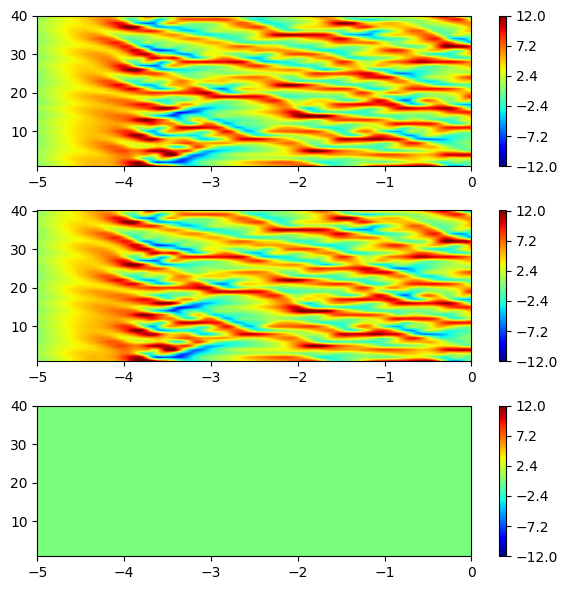

In [28]:
#%%
ns = int(t_start/dt)
nt = int(t_end/dt)
fr = 10.0
nf = 10         # frequency of observation
nb = int(nt/nf) # number of observation time
ti = np.linspace(-t_start,0,ns)
t = np.linspace(0,t_end,nt)
tobs = np.linspace(0,t_end,nb)
x = np.linspace(1,N,N)

Xi,Ti = np.meshgrid(x,ti,indexing='ij')

vmin = -12
vmax = 12
fig, ax = plt.subplots(3,1,figsize=(6,6))
cs = ax[0].contourf(Ti,Xi,X_state.T,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(X_state.T)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[0],ticks=np.linspace(vmin, vmax, 6))

cs = ax[1].contourf(Ti,Xi,X_state_estimated.T,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(X_state_estimated.T)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[1],ticks=np.linspace(vmin, vmax, 6))

cs = ax[2].contourf(Ti,Xi,(X_state.T-X_state_estimated.T),120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array((X_state.T-X_state_estimated.T))
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[2],ticks=np.linspace(vmin, vmax, 6))

fig.tight_layout()
plt.show()